# Meeting Pattern

O objetivo deste projeto é identificar qual o padrão dos leads para que haja conexão e agendamento, ou seja, geração de oportunidade.

Abordaremos desta maneira devido ao objetivo de melhorar a taxa de conversão entre um lead gerado e qualificado por marketing até a oportunidade gerada. Além disso, o volume é muito maior quando se comparado com o número de clientes, dando uma possibilidade de um estudo ainda mais consistente.

## Libs

In [1]:
import requests
import urllib3
import numpy as np
import pandas as pd
import json
import datetime
from tqdm import tqdm
import time
import collections

## Bases

In [2]:
rd = pd.read_csv('data/rdstation.csv', low_memory=False)

In [3]:
events = pd.read_csv('data/conversoes.csv', sep="\t")

In [4]:
exact = pd.read_csv('data/exact.csv', sep=';', encoding='utf-8')

In [5]:
rd.shape

(59721, 182)

### Tratamento das bases

1) RD Station

In [6]:
#Dropar todas as colunas que não possuem nenhuma informação
rd = rd.dropna(axis=1, how='all')

#selecionar todas as colunas que possuem + 300 eventos registrados
rd = rd[rd.columns[rd.count()>300]]

#dropar as colunas que não utilizamos para analisar os dados
rd.drop(labels=['Celular', 'Cidade', 'Estado', 'Pais', 'Mercado', 'Produto', 'Dadoscoletados', 'Origem.1', 'Company', \
                    'Id', 'Trialstart', 'Trialend', 'Import token', 'Submit-om', 'Possui-sistema-de-atendimento', \
                    'Newsletter', 'Form url', 'Siteempresa','Created at', 'Page title', 'Conversion page', 'Istest', 'Tags', \
                    'Octadesksubdomain', 'Message', 'Octadeskemail', 'Istrial', 'Hascreatedaccount', 'Traffic Source', \
                    'Sh0uldn07ch4ng3', 'Custom fields[274]', 'Custom fields[14137]', \
                    'Custom fields[28126]', 'Custom fields[28308]', 'Custom fields[266]', \
                    'Custom fields[270]', 'Custom fields[268]', 'Qual seu maior problema?', \
                    'Custom fields[148136]', 'Vertical', 'Já utiliza sistema de atendimento?', \
                    'Custom fields[98378]', 'Custom fields[15144]', 'Custom fields[16314]', 'Field 0 hidden', 'Field 1 hidden', \
                    'Dores', 'Motivodescarte', 'Etapadescarte', 'Prevendedor', 'Emailprevendedor',\
                    'Qualificacaofiltro1','Qualificacaofiltro2', 'Qualificacaofeedbackvisita', 'Etapaatual','Vendedor'], axis=1, inplace=True)

#Splitar a Origem e criar duas colunas
#medium
rd['rd_medium'] = rd['Origem'].str.split('|').str[0]
rd['rd_medium'] = rd['rd_medium'].str.strip()

#source
rd['rd_source'] = rd['Origem'].str.split('|').str[1]
rd['rd_source'] = rd['rd_source'].str.strip()

#drop Origem
rd.drop(labels=['Origem'], axis=1, inplace=True)


In [7]:
#Normalizar a data de conversão
rd['conv_date'] = pd.DatetimeIndex(rd['Data da Conversão']).normalize()
conv_date = rd['conv_date']
rd['conv_date'] = pd.to_datetime(rd['conv_date'], format='%d/%m/%Y')
rd.drop(labels=['conv_date', 'Data da Conversão'], axis=1,inplace = True)
rd.insert(0, 'conv_date', conv_date)

In [8]:
#renomear as colunas
rd = rd.rename(index=str, columns={'Identificador': 'event', 'Nome': 'name', \
                                  'Telefone': 'phone', 'Utm campaign': 'utm_campaign', \
                                  'Utm medium': 'utm_medium', 'Utm source':'utm_source', \
                                  'Email lead': 'email', 'Website': 'site', \
                                  'Qual é o seu cargo?': 'job_title', 'Departamento': 'department',
                                  'Numero-de-funcionarios': 'n_employees', 'Gerenciamento': 'management',
                                  'Utm content': 'utm_content', 'Utm term': 'utm_term',
                                  'Número de funcionários': 'n_employees 2', 'Empresa': 'company_name'})

In [9]:
#Juntar as colunas de número de funcionários
rd['n_employees'] = rd[['n_employees', 'n_employees 2']].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
rd.drop('n_employees 2', axis=1, inplace = True)

#Juntar as colunas de cargo
rd['job_title'] = rd[['Cargo', 'job_title']].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
rd.drop('Cargo', axis=1, inplace = True)


In [10]:
#employee
rd['n_employees'].replace('1 a 10', '1-10', inplace=True)
rd['n_employees'].replace('11 a 30', '11-30', inplace=True)
rd['n_employees'].replace('de 11 a 30 ', '11-30', inplace=True)
rd['n_employees'].replace('de 6 a 10', '1-10', inplace=True)
rd['n_employees'].replace('de 6 a 10 ', '1-10', inplace=True)
rd['n_employees'].replace('6 a 10', '6-10', inplace=True)
rd['n_employees'].replace('1 a 5', '1-5', inplace=True)
rd['n_employees'].replace('de 1 a 5', '1-5', inplace=True)
rd['n_employees'].replace('31 a 50', '31-50', inplace=True)
rd['n_employees'].replace('51 a 100', '51-100', inplace=True)
rd['n_employees'].replace('acima de 1001', '101+', inplace=True)
rd['n_employees'].replace('251 a 500', '101+', inplace=True)
rd['n_employees'].replace('de 251 a 500', '101+', inplace=True)
rd['n_employees'].replace('de 101 a 250', '101+', inplace=True)
rd['n_employees'].replace('500 a 1000', '101+', inplace=True)
rd['n_employees'].replace('101 a 250', '101+', inplace=True)
rd['n_employees'].replace('de 501 a 1000', '101+', inplace=True)
rd['n_employees'].replace('1-5', '1-5', inplace=True)
rd['n_employees'].replace('6-10', '6-10', inplace=True)
rd['n_employees'].replace('11-20', '11-30', inplace=True)
rd['n_employees'].replace('Mais de 20', '11-30', inplace=True)
rd['n_employees'].replace('undefined', np.nan, inplace=True)

In [11]:
#outros cargos
rd['job_title'].replace('CONSULTOR', 'Outros Cargos', inplace=True)
rd['job_title'].replace('Consultor', 'Outros Cargos', inplace=True)
rd['job_title'].replace('Assistente Comercial', 'Outros Cargos', inplace=True)
rd['job_title'].replace('Administração', 'Outros Cargos', inplace=True)
rd['job_title'].replace('Representante', 'Outros Cargos', inplace=True)
rd['job_title'].replace('Consultor Empresarial', 'Outros Cargos', inplace=True)
rd['job_title'].replace('Representante Comercial', 'Outros Cargos', inplace=True)
rd['job_title'].replace('Outros cargos', 'Outros Cargos', inplace=True)
rd['job_title'].replace('Outro', 'Outros Cargos', inplace=True)
rd['job_title'].replace('undefined', 'Outros Cargos', inplace=True)


#coordenador
rd['job_title'].replace('Supervisor(a) / Coordenador(a)', 'Supervisor', inplace=True)
rd.loc[rd['job_title'].str.contains('supervisor'), 'job_title'] = 'Supervisor'
rd.loc[rd['job_title'].str.contains('Supervisor'), 'job_title'] = 'Supervisor'
rd.loc[rd['job_title'].str.contains('SUPERVISOR'), 'job_title'] = 'Supervisor'

#socio
rd['job_title'].replace('Empresário / CEO', 'Sócio / CEO', inplace=True)
rd['job_title'].replace('Executivo', 'Sócio / CEO', inplace=True)
rd['job_title'].replace('propietario', 'Sócio / CEO', inplace=True)
rd['job_title'].replace('Presidência', 'Sócio / CEO', inplace=True)
rd['job_title'].replace('CEO', 'Sócio / CEO', inplace=True)
rd.loc[rd['job_title'].str.contains('ceo'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('Ceo'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('CEO'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('Sócio'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('sócio'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('SÓCIO'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('Socio'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('socio'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('SOCIO'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('SÛcio'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('Dono'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('Owner'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('Founder'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('founder'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('Proprietário'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('Propietário'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('Presidente'), 'job_title'] = 'Sócio / CEO'
rd.loc[rd['job_title'].str.contains('presidente'), 'job_title'] = 'Sócio / CEO'

#Diretor
rd['job_title'].replace('Diretor Comercial', 'Diretor', inplace=True)
rd.loc[rd['job_title'].str.contains('Diretor'), 'job_title'] = 'Diretor'
rd.loc[rd['job_title'].str.contains('DIRETOR'), 'job_title'] = 'Diretor'
rd.loc[rd['job_title'].str.contains('diretor'), 'job_title'] = 'Diretor'

#gerente
rd['job_title'].replace('Gerente de Vendas', 'Gerente', inplace=True)
rd['job_title'].replace('Gestor de Vendas', 'Gerente', inplace=True)
rd['job_title'].replace('Gestor de Marketing', 'Gerente', inplace=True)
rd.loc[rd['job_title'].str.contains('Gerente'), 'job_title'] = 'Gerente'
rd.loc[rd['job_title'].str.contains('gerente'), 'job_title'] = 'Gerente'
rd.loc[rd['job_title'].str.contains('GERENTE'), 'job_title'] = 'Gerente'
rd.loc[rd['job_title'].str.contains('Responsável'), 'job_title'] = 'Gerente'
rd.loc[rd['job_title'].str.contains('GESTOR'), 'job_title'] = 'Gerente'
rd.loc[rd['job_title'].str.contains('gestor'), 'job_title'] = 'Gerente'
rd.loc[rd['job_title'].str.contains('Gestor'), 'job_title'] = 'Gerente'


#vendedor / atendente
rd['job_title'].replace('vendedor', 'Vendedor / atendente', inplace=True)
rd['job_title'].replace('Atendente', 'Vendedor / atendente', inplace=True)
rd['job_title'].replace('Vendedor Externo', 'Vendedor / atendente', inplace=True)
rd['job_title'].replace('Vendedor Interno', 'Vendedor / atendente', inplace=True)

#analista
rd.loc[rd['job_title'].str.contains('Analista'), 'job_title'] = 'Analista'
rd.loc[rd['job_title'].str.contains('analista'), 'job_title'] = 'Analista'
rd.loc[rd['job_title'].str.contains('ANALISTA'), 'job_title'] = 'Analista'

#Coordenador
rd.loc[rd['job_title'].str.contains('Coordenador'), 'job_title'] = 'Coordenador'
rd.loc[rd['job_title'].str.contains('coordenador'), 'job_title'] = 'Coordenador'
rd.loc[rd['job_title'].str.contains('COORDENADOR'), 'job_title'] = 'Coordenador'

In [12]:
#Somar Todos os valores abaixo de 15 para Outros Cargos
g = rd.groupby('job_title')
g.filter(lambda x: len(x) <= 15)
rd.loc[g['job_title'].transform(lambda x: len(x) <= 15).astype(bool), 'job_title'] = 'Outros Cargos'

In [13]:
#remover '/' dos eventos
rd.event.replace(regex=True,inplace=True,to_replace=r'/',value=r'')

In [14]:
#Substituir medium de Social para Facebook ou LinkedIn
rd.rd_medium.replace('Social', rd.rd_source, inplace=True)

#Substituir Desconhecido para utm_medium
rd.rd_medium.replace('Desconhecido', rd.utm_medium, inplace=True)

In [15]:
#substituir valores de utm_medium para o padrão RD
rd.rd_medium.replace('social', rd.utm_source, inplace=True)


In [16]:
#cargo -> 'Custom fields[44611]'
rd.job_title.replace(np.nan, rd['Custom fields[44611]'], inplace=True)

In [17]:
#area -> Custom fields[44612]
rd.department.replace(np.nan, rd['Custom fields[44612]'], inplace=True)

In [18]:
#quantidade funcionário Custom fields[265]
rd.n_employees.replace(np.nan, rd['Custom fields[265]'], inplace=True)


In [19]:
rd.job_title.replace(r'', np.nan, regex=True, inplace=True)
rd.n_employees.replace(r'', np.nan, regex=True, inplace=True)

In [20]:
#substituir valores para grupos maiores
rd.rd_medium.replace('cpc', 'Busca Paga', inplace=True)
rd.rd_medium.replace('organic', 'Busca Orgânica', inplace=True)
rd.rd_medium.replace('email', 'Email', inplace=True)
rd.rd_medium.replace('cpc', 'Busca Paga', inplace=True)
rd.rd_medium.replace('facebook', 'Facebook', inplace=True)
rd.rd_medium.replace('referral', 'Referência', inplace=True)
rd.rd_medium.replace('linkedin', 'LinkedIn', inplace=True)
rd.rd_medium.replace('Facebook Ads', 'Facebook', inplace=True)
rd.rd_medium.replace('n/a', 'Desconhecido', inplace=True)
rd.rd_medium.replace('none', 'Desconhecido', inplace=True)
rd.rd_medium.replace('banner-blog', 'Desconhecido', inplace=True)
rd.rd_medium.replace('blog', 'Desconhecido', inplace=True)
rd.rd_medium.replace('Instagram', 'Desconhecido', inplace=True)
rd.rd_medium.replace('link-site', 'Desconhecido', inplace=True)
rd.rd_medium.replace('button-site', 'Desconhecido', inplace=True)
rd.rd_medium.replace('Twitter', 'Desconhecido', inplace=True)
rd.rd_medium.replace('Pinterest', 'Desconhecido', inplace=True)
rd.rd_medium.replace('Partner', 'Email', inplace=True)
rd.rd_medium.replace('link-blog', 'Email', inplace=True)
rd.rd_medium.replace('Blogger', 'Email', inplace=True)

In [21]:
rd.rd_medium.fillna('Desconhecido', inplace=True)

1) a) Eventos

In [22]:
events = pd.read_excel('data/events 2.xlsx')

In [23]:
#dropar a coluna ID
events.drop('ID', axis=1, inplace=True)

In [24]:
#criar uma coluna na base RD com a classificação dos materiais
#rd = rd.merge(events, how='left', on="event")
rd_events = events.drop_duplicates('event', keep='first').set_index('event')['funnel']
rd['funnel'] = rd['event'].map(rd_events)

2) Exact Sales

In [25]:
#Dropar todas as colunas que não possuem nenhuma informação
exact = exact.dropna(axis=1, how='all')

#Dropar as colunas que não necessitam para a análise
exact.drop(labels=['Nome da Empresa', 'Dt. Venda', 'Dt. Última Atualização',\
                   'Produto', 'Site', 'Data Descarte', 'LinkMarketing', 'Motivo descarte',\
                   'País', 'Estado', 'Cidade', 'Telefone 1', 'Telefone 2', 'Observação',\
                   'Dores Lead', 'Produtos Sugeridos', 'Produtos Vendidos','Cargo Contato 1',\
                   'Telefone 1 Contato 1', 'Telefone 2 Contato 1', 'Nome Contato 2',\
                   'E-mail Contato 2', 'Cargo Contato 2', 'Telefone 1 Contato 2',\
                   'Telefone 2 Contato 2', 'Nome Contato 3', 'E-mail Contato 3','Nome Contato 1',\
                   'Cargo Contato 3', 'Telefone 1 Contato 3', 'E-mail Pré-vendedor', \
                    'Telefone 2 Contato 3', 'Dt. Último Resgate'], axis=1, inplace=True)

In [26]:
## Ajuste das datas para padrão d/m/Y

#create date
exact['Data de Criação'] = pd.to_datetime(exact['Data de Criação'], format='%d/%m/%Y')

#booking date
exact['Dt. Agend. reunião'] = exact['Dt. Agend. reunião'].str.split(' ').str[0]
exact['Dt. Agend. reunião'] = pd.to_datetime(exact['Dt. Agend. reunião'], format='%d/%m/%Y')

#meeting date
exact['Dt. Reunião'] = exact['Dt. Reunião'].str.split(' ').str[0]
exact['Dt. Reunião'] = pd.to_datetime(exact['Dt. Reunião'], format='%d/%m/%Y')

#feedback date
exact['Dt. Preenc. Feedback'] = exact['Dt. Preenc. Feedback'].str.split(' ').str[0]
exact['Dt. Preenc. Feedback'] = pd.to_datetime(exact['Dt. Preenc. Feedback'], format='%d/%m/%Y')

#filter 1 date
exact['Dt. Filtro 1'] = exact['Dt. Filtro 1'].str.split(' ').str[0]
exact['Dt. Filtro 1'] = pd.to_datetime(exact['Dt. Filtro 1'], format='%d/%m/%Y')

#filter 2 date
exact['Dt. Filtro 2'] = exact['Dt. Filtro 2'].str.split(' ').str[0]
exact['Dt. Filtro 2'] = pd.to_datetime(exact['Dt. Filtro 2'], format='%d/%m/%Y')

In [27]:
#Renomear as colunas
#renomear as colunas
exact = exact.rename(index=str, columns={'Data de Criação':'qualified_date', 'Origem': 'type',\
                                        'Sub-Origem': 'sub_type', 'Etapa Atual': 'stage', 'Mercado':'vertical', \
                                        'Pontuação': 'score', 'Dt. Agend. reunião': 'scheduling_date',\
                                        'Dt. Reunião': 'meeting_date', 'Qualificação Feedback': 'feedback_score',\
                                        'Dt. Preenc. Feedback': 'feedback_date', 'Etapa Descarte': 'lost_stage',\
                                        'Data Descarte': 'lost_date', \
                                        'Nome do Vendedor': 'salesperson', 'Nome Pré-Vendedor':'sdr',\
                                        'E-mail Contato 1': 'email', 'Qualificação Filtro 1': 'filter1_score',\
                                        'Qualificação Filtro 2': 'filter2_score', 'Dt. Filtro 1' : 'filter1_date',\
                                        'Dt. Filtro 2': 'filter2_date'})

In [28]:
##replaces de salespearson e sdr
exact.salesperson.replace('Artur Mendes', 'artur', inplace=True)
exact.salesperson.replace('Juliana Brito', 'juliana', inplace=True)
exact.salesperson.replace('Daniela Degaspare', 'outros', inplace=True)
exact.salesperson.replace('Rodrigo Ricco', 'outros', inplace=True)

#sdr
exact.sdr.replace('Letícia Lemos', 'leticia', inplace=True)
exact.sdr.replace('Flávio Galvão', 'flavio', inplace=True)
exact.sdr.replace('Israel Rodrigues', 'israel', inplace=True)
exact.sdr.replace('Artur Pré-Venda', 'artur', inplace=True)
exact.sdr.replace('Juliana Pré-Vendas', 'juliana', inplace=True)
exact.sdr.replace('Alessandra Dias', 'outros', inplace=True)
exact.sdr.replace('Flavia Lima', 'flavia', inplace=True)
exact.sdr.replace('Daniela Pré-Vendas', 'outros', inplace=True)

In [29]:
##normalizar as datas
exact['qualified_date'] = pd.DatetimeIndex(exact['qualified_date']).normalize()
exact['scheduling_date'] = pd.DatetimeIndex(exact['scheduling_date']).normalize()
exact['meeting_date'] = pd.DatetimeIndex(exact['meeting_date']).normalize()
exact['feedback_date'] = pd.DatetimeIndex(exact['feedback_date']).normalize()
exact['filter1_date'] = pd.DatetimeIndex(exact['filter1_date']).normalize()
exact['filter2_date'] = pd.DatetimeIndex(exact['filter2_date']).normalize()

In [30]:
##Score em números para facilitar o dataset

#feedbackscore
exact.feedback_score.replace('Muito Quente', 4, inplace=True)
exact.feedback_score.replace('Quente', 3, inplace=True)
exact.feedback_score.replace('Morna', 2, inplace=True)
exact.feedback_score.replace('Fria', 1, inplace=True)
exact.feedback_score.replace('Congelada', 0, inplace=True)

#filter1
exact.filter1_score.replace('Muito Quente', 4, inplace=True)
exact.filter1_score.replace('Quente', 3, inplace=True)
exact.filter1_score.replace('Morna', 2, inplace=True)
exact.filter1_score.replace('Fria', 1, inplace=True)
exact.filter1_score.replace('Congelada', 0, inplace=True)

#filter2
exact.filter2_score.replace('Muito Quente', 4, inplace=True)
exact.filter2_score.replace('Quente', 3, inplace=True)
exact.filter2_score.replace('Morna', 2, inplace=True)
exact.filter2_score.replace('Fria', 1, inplace=True)
exact.filter2_score.replace('Congelada', 0, inplace=True)

In [31]:
#Criar colunas para identificar até qual etapa de vendas o lead foi

#entry, filter_one, filter_two, meeting, sales
exact['entry'] = 1
exact['filter_one'] = np.where(np.logical_or(np.isnan(exact.filter1_score),np.isnat(exact.filter1_date)), 0,1 )
exact['filter_two'] = np.where(np.logical_or(np.isnan(exact.filter2_score),np.isnat(exact.filter2_date)), 0,1 )
exact['meeting'] = np.where((np.isnan(exact.feedback_score)) & (np.isnat(exact.meeting_date)) & \
                            (np.isnat(exact.feedback_date)) & (np.isnat(exact.scheduling_date)),0,1)

In [32]:
#tempo entre etapas até o agendamento
exact['time_to_filter1'] = ((exact.filter1_date - exact.qualified_date) / np.timedelta64(1, 'D'))
exact.time_to_filter1 = exact.time_to_filter1.fillna(0)
exact['time_to_filter2'] = ((exact.filter2_date - exact.filter1_date) / np.timedelta64(1, 'D'))
exact.time_to_filter2 = exact.time_to_filter2.fillna(0)
exact['time_to_meeting'] = ((exact.meeting_date - exact.filter2_date) / np.timedelta64(1, 'D'))
exact.time_to_meeting = exact.time_to_meeting.fillna(0)
exact['time_qualified_to_meeting'] = ((exact.meeting_date - exact.qualified_date) / np.timedelta64(1, 'D'))
exact.time_qualified_to_meeting = exact.time_qualified_to_meeting.fillna(0)

In [33]:
exact.columns

Index(['qualified_date', 'type', 'sub_type', 'vertical', 'CP: utm_campaign',
       'CP: utm_source', 'CP: utm_medium', 'CP: Gerenciamento',
       'CP: Número de funcionários', 'CP: Departamento',
       'CP: Maiores desafios', 'stage', 'score', 'scheduling_date',
       'meeting_date', 'feedback_score', 'feedback_date', 'lost_stage',
       'salesperson', 'sdr', 'email', 'filter1_score', 'filter1_date',
       'filter2_score', 'filter2_date', 'F1 - Quantidade de funcionários?',
       'F1 - Possui filial?', 'F1 - Possui canais de contato on-line? ',
       'F1 - Possui chat de atendimento?',
       'F1 - Aparentemente possui volume expressivo de clientes?',
       'F1 - Possui ferramenta de help-desk?',
       'F2 - Onde gerencia os atendimentos?', 'F2 - Quanto tempo está usando?',
       'F2 - Quantas ocorrências estão atendendo por dia? ',
       'F2 - Hoje você conhece os principais indicadores que apontam a saúde da sua operação?',
       'F2 - Existe um padrão de solução para ca

In [34]:
exact['opo_date'] = exact.loc[:, ['scheduling_date', 'meeting_date']].min(axis=1)

In [35]:
#Organizar as colunas na melhor ordem de trabalho
exact = exact[['email', 'qualified_date','opo_date','vertical','type', 'sub_type', 'sdr', \
              'salesperson', 'score', 'filter1_score', 'filter2_score', \
              'feedback_score', 'entry', 'filter_one','time_to_filter1', 'stage', 'lost_stage',\
               'filter_two','time_to_filter2', 'meeting', 'time_to_meeting', 'time_qualified_to_meeting']]

In [36]:
#dropar linhas que não possuem emails
exact.dropna(subset=['email'], inplace=True)

3) Dataset

In [37]:
#criar feature de target
exact_meeting = exact[['email', 'meeting']]
es_meeting_type = exact_meeting.drop_duplicates('email', keep='first').set_index('email')['meeting']
rd['target'] = rd['email'].map(es_meeting_type)
rd['target'].fillna(0, inplace=True)

In [38]:
#hard time: criar coluna de tofu, mofu e bofu antes de virar MQL

rd = rd.sort_values(by=['conv_date'], ascending=True)

#etapa 1: subir uma coluna com a data de envio do lead para o time de vendas
#etapa 2: criar uma tabela separada da 'rd' com os e-mails únicos
#etapa 3: conseguir filtrar, para cada lead, a data de corte para contagem das conversões

#etapa 1
exact_create_date = exact[['email', 'qualified_date', 'type']]
es_qualified_date = exact_create_date.drop_duplicates('email', keep='first').set_index('email')['qualified_date']
rd['qualified_date'] = rd['email'].map(es_qualified_date)

exact_opo_date = exact[['email', 'opo_date', 'type']]
es_opo_date = exact_opo_date.drop_duplicates('email', keep='first').set_index('email')['opo_date']
rd['opo_date'] = rd['email'].map(es_opo_date)

es_type = exact_create_date.drop_duplicates('email', keep='first').set_index('email')['type']
rd['type'] = rd['email'].map(es_type)

exact_vertical = exact[['email', 'vertical']]
es_vertical = exact_vertical.drop_duplicates('email', keep='first').set_index('email')['vertical']
rd['vertical'] = rd['email'].map(es_vertical)

exact_sdr = exact[['email', 'sdr']]
es_sdr = exact_sdr.drop_duplicates('email', keep='first').set_index('email')['sdr']
rd['sdr'] = rd['email'].map(es_sdr)

exact_salesperson = exact[['email', 'salesperson']]
es_salesperson = exact_salesperson.drop_duplicates('email', keep='first').set_index('email')['salesperson']
rd['salesperson'] = rd['email'].map(es_salesperson)


#sub etapa) criar coluna com variação entre data de qualificação para data de conversão
rd['qualified-conv-date'] = ((rd.qualified_date - rd.conv_date) / np.timedelta64(1, 'D'))
rd['qualified-conv-date'] = rd['qualified-conv-date'].fillna(0)

#sub etapa 2) criar coluna com variação entre data de agendamento para data de conversão
rd['opo-conv-date'] = ((rd.opo_date - rd.conv_date) / np.timedelta64(1, 'D'))
rd['opo-conv-date'] = rd['opo-conv-date'].fillna(0)

In [39]:
#dropar eventos nulos
rd = rd.dropna(axis=0, how='any', subset=['event'])

In [40]:
#etapa 1a) criar dummies
rd = pd.get_dummies(rd, columns=['funnel'], drop_first=False)

In [41]:
#etapa 2a) leads que já foram qualificados, contar somente as conversões antes de virar MQL
rd2 = rd.copy()

#base
rd2 = rd2[rd2['opo-conv-date'] >= 0]
rd2 = rd2[rd2['event'] != 'IntegracaoExact']

#somar conversões por etapa do funil
rd2['freq_infografico'] = rd2.groupby('email')['funnel_Infografico'].transform('sum')
rd2['freq_planilha'] = rd2.groupby('email')['funnel_Planilha'].transform('sum')
rd2['freq_webinar'] = rd2.groupby('email')['funnel_Webinar'].transform('sum')
rd2['freq_checklist'] = rd2.groupby('email')['funnel_checklist'].transform('sum')
rd2['freq_ebook'] = rd2.groupby('email')['funnel_ebook'].transform('sum')
rd2['freq_kit'] = rd2.groupby('email')['funnel_kit'].transform('sum')
rd2['freq_levantada_mao'] = rd2.groupby('email')['funnel_levantada_mao'].transform('sum')
rd2['freq_newsletter'] = rd2.groupby('email')['funnel_newsletter'].transform('sum')
rd2['freq_outros'] = rd2.groupby('email')['funnel_outros'].transform('sum')
rd2['freq_pesquisa'] = rd2.groupby('email')['funnel_pesquisa'].transform('sum')

In [42]:
#drop nas colunas que não interessam (mantendo as colunas que interessam)
rd2 = rd2[['conv_date', 'email', 'freq_infografico', 'freq_planilha', 'freq_webinar', 'freq_checklist',\
          'freq_ebook', 'freq_kit','freq_levantada_mao','freq_newsletter',  'freq_outros', 'freq_pesquisa']]

rd2 = rd2.sort_values(by=['conv_date'], ascending=True)

In [43]:
#incluir os dados na tabela rd
rd_infografico = rd2.drop_duplicates('email', keep='first').set_index('email')['freq_infografico']
rd['freq_infografico'] = rd['email'].map(rd_infografico)

rd_planilha = rd2.drop_duplicates('email', keep='first').set_index('email')['freq_planilha']
rd['freq_planilha'] = rd['email'].map(rd_planilha)

rd_webinar = rd2.drop_duplicates('email', keep='first').set_index('email')['freq_webinar']
rd['freq_webinar'] = rd['email'].map(rd_webinar)

rd_checklist = rd2.drop_duplicates('email', keep='first').set_index('email')['freq_checklist']
rd['freq_checklist'] = rd['email'].map(rd_checklist)

rd_ebook = rd2.drop_duplicates('email', keep='first').set_index('email')['freq_ebook']
rd['freq_ebook'] = rd['email'].map(rd_ebook)

rd_kit = rd2.drop_duplicates('email', keep='first').set_index('email')['freq_kit']
rd['freq_kit'] = rd['email'].map(rd_kit)

rd_levantada = rd2.drop_duplicates('email', keep='first').set_index('email')['freq_levantada_mao']
rd['freq_levantada_mao'] = rd['email'].map(rd_levantada)

rd_newsletter = rd2.drop_duplicates('email', keep='first').set_index('email')['freq_newsletter']
rd['freq_newsletter'] = rd['email'].map(rd_newsletter)

rd_outros = rd2.drop_duplicates('email', keep='first').set_index('email')['freq_outros']
rd['freq_outros'] = rd['email'].map(rd_outros)

rd_pesquisa = rd2.drop_duplicates('email', keep='first').set_index('email')['freq_pesquisa']
rd['freq_pesquisa'] = rd['email'].map(rd_pesquisa)

rd = rd[rd['event'] != 'IntegracaoExact']

In [44]:
#puxar a primeira origem do lead
rd_source_first_conv = rd.drop_duplicates('email', keep='first').set_index('email', 'conv_date')['rd_medium']
rd_source_first_conv.sort_values(ascending=True)
rd['source_first_conv'] = rd['email'].map(rd_source_first_conv)

#puxar a primeira conversão do lead
rd_event_first_conv = rd.drop_duplicates('email', keep='first').set_index('email', 'conv_date')['event']
rd_event_first_conv.sort_values(ascending=True)
rd['event_first_conv'] = rd['email'].map(rd_event_first_conv)


#puxar a última origem do lead
rd_source_last_conv = rd.drop_duplicates('email', keep='last').set_index('email', 'conv_date')['rd_medium']
rd_source_last_conv.sort_values(ascending=False)
rd['source_last_conv'] = rd['email'].map(rd_source_last_conv)

#puxar a primeira conversão do lead
rd_event_last_conv = rd.drop_duplicates('email', keep='last').set_index('email', 'conv_date')['event']
rd_event_last_conv.sort_values(ascending=False)
rd['event_last_conv'] = rd['email'].map(rd_event_last_conv)

#puxar o número total de conversões
rd_conversions = pd.DataFrame()
rd_conversions['email'] = rd['email']
rd_conversions['freq'] = rd_conversions.groupby('email')['email'].transform('count')
rd_conversions = rd_conversions.drop_duplicates('email', keep='first').set_index('email')['freq']
rd['conversions'] = rd['email'].map(rd_conversions)
rd['conversions']=rd['conversions'].fillna(0)

In [45]:
#colunas de management, job_title e outras classificações que podem vir em outras conversões
rd4 = rd.copy()
rd4 = rd4.sort_values(by=['conv_date'], ascending=True)

#site
rd_site = rd4[['email', 'site']]
rd_site.dropna(axis=0, how='any', inplace=True)
rd_site = rd_site.drop_duplicates('email', keep='first').set_index('email')['site']
rd['site'] = rd['email'].map(rd_site)

#utm_campaign
rd_utm_campaign = rd4[['email', 'utm_campaign']]
rd_utm_campaign.dropna(axis=0, how='any', inplace=True)
rd_utm_campaign = rd_utm_campaign.drop_duplicates('email', keep='first').set_index('email')['utm_campaign']
rd['utm_campaign'] = rd['email'].map(rd_utm_campaign)

#utm_medium
rd_utm_medium = rd4[['email', 'utm_medium']]
rd_utm_medium.dropna(axis=0, how='any', inplace=True)
rd_utm_medium = rd_utm_medium.drop_duplicates('email', keep='first').set_index('email')['utm_medium']
rd['utm_medium'] = rd['email'].map(rd_utm_medium)

#utm_source
rd_utm_source = rd4[['email', 'utm_source']]
rd_utm_source.dropna(axis=0, how='any', inplace=True)
rd_utm_source = rd_utm_source.drop_duplicates('email', keep='first').set_index('email')['utm_source']
rd['utm_source'] = rd['email'].map(rd_utm_source)

#rd_medium
rd_rd_medium = rd4[['email', 'rd_medium']]
rd_rd_medium.dropna(axis=0, how='any', inplace=True)
rd_rd_medium = rd_rd_medium.drop_duplicates('email', keep='first').set_index('email')['rd_medium']
rd['rd_medium'] = rd['email'].map(rd_rd_medium)

#rd_source
rd_rd_source = rd4[['email', 'rd_source']]
rd_rd_source.dropna(axis=0, how='any', inplace=True)
rd_rd_source = rd_rd_source.drop_duplicates('email', keep='first').set_index('email')['rd_source']
rd['rd_source'] = rd['email'].map(rd_rd_source)

#department
rd_department = rd4[['email', 'department']]
rd_department.dropna(axis=0, how='any', inplace=True)
rd_department = rd_department.drop_duplicates('email', keep='first').set_index('email')['department']
rd['department'] = rd['email'].map(rd_department)

#n_employees
rd_n_employees = rd4[['email', 'n_employees']]
rd_n_employees.dropna(axis=0, how='any', inplace=True)
rd_n_employees = rd_n_employees.drop_duplicates('email', keep='first').set_index('email')['n_employees']
rd['n_employees'] = rd['email'].map(rd_n_employees)

#management
rd_management = rd4[['email', 'management']]
rd_management.dropna(axis=0, how='any', inplace=True)
rd_management = rd_management.drop_duplicates('email', keep='first').set_index('email')['management']
rd['management'] = rd['email'].map(rd_management)

#job_title
rd_job_title = rd4[['email', 'job_title']]
rd_job_title.dropna(axis=0, how='any', inplace=True)
rd_job_title = rd_job_title.drop_duplicates('email', keep='first').set_index('email')['job_title']
rd['job_title'] = rd['email'].map(rd_job_title)

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set

In [46]:
#validação do email (corporativo ou não)

#load da base
free_domain = pd.read_csv('data/free_domain_list.csv', sep=',')

#criar coluna categórica (0 para free e 1 para diferente da free)
free_domain['domain_type'] = 0

In [47]:
#criar uma coluna com domain
rd['email_domain'] = rd['email'].str.split('@').str[1]
rd['email_domain'] = rd['email_domain'].str.strip()

In [48]:
#puxar os dados da tabela free_domain
rd_free_domain = free_domain.drop_duplicates('domain', keep='first').set_index('domain')['domain_type']
rd['email_domain_type'] = rd['email_domain'].map(rd_free_domain)

In [49]:
#preencher com 1 os valores vazios
rd.email_domain_type.fillna(1, inplace=True)

#### Integração com os dados do pipedrive

In [50]:
pipedrive = pd.read_csv('data/pipedrive.csv', sep=',', low_memory=False)

In [51]:
pipedrive['Deal - Data atualizada'] = pd.DatetimeIndex(pipedrive['Deal - Data atualizada']).normalize()
pipedrive['Deal - Data de perda'] = pd.DatetimeIndex(pipedrive['Deal - Data de perda']).normalize()
pipedrive['Deal - Negócio criado em'] = pd.DatetimeIndex(pipedrive['Deal - Negócio criado em']).normalize()
pipedrive['Deal - Última alteração de etapa'] = pd.DatetimeIndex(pipedrive['Deal - Última alteração de etapa']).normalize()
pipedrive['Deal - Data de ganho'] = pd.DatetimeIndex(pipedrive['Deal - Data de ganho']).normalize()
pipedrive['Deal - Data da Próxima Atividade'] = pd.DatetimeIndex(pipedrive['Deal - Data da Próxima Atividade']).normalize()
pipedrive['Deal - Data da Última Atividade'] = pd.DatetimeIndex(pipedrive['Deal - Data da Última Atividade']).normalize()
pipedrive['Deal - Data de fechamento esperada'] = pd.DatetimeIndex(pipedrive['Deal - Data de fechamento esperada']).normalize()
pipedrive['Deal - Negócio fechado em'] = pd.DatetimeIndex(pipedrive['Deal - Negócio fechado em']).normalize()

In [52]:
create = pipedrive['Deal - Negócio criado em']
pipedrive.drop(labels=['Deal - Negócio criado em'], axis=1,inplace = True)
pipedrive.insert(0, 'Create', create)

email = pipedrive['Person - E-mail']
pipedrive.drop(labels=['Person - E-mail'], axis=1,inplace = True)
pipedrive.insert(1, 'email', email)


pipedrive.reset_index(inplace=True)
pipedrive.drop(labels=['index'], axis=1,inplace = True)

In [53]:
#Encontrar campos com emails duplos
pipedrive['2 Emails'] = np.where(pipedrive['email'].str.contains(',' or '/'),1,0)
pipedrive = pipedrive.sort_values(by='2 Emails', ascending=False)
pipedrive['2 Emails'].value_counts()
pipedrive['Email 1'], pipedrive['Email 2'], pipedrive['Email 3'] = pipedrive['email'].str.split(',' or '/', 2).str
pipedrive['binary'] = 1

In [54]:
##Pipedrive
#final['is_pipedrive']
pp_ispipedrive = pipedrive[['email', 'binary']]
pp_ispipedrive.drop_duplicates('email', inplace=True)
pp_ispipedrive.set_index('email', inplace=True)
rd = rd.join(pp_ispipedrive, on='email', how='left', lsuffix='_final', rsuffix='_pipedrive')
rd['is_pipedrive'] = rd['binary']
rd.drop('binary', inplace=True, axis=1)
rd['is_pipedrive']=rd['is_pipedrive'].fillna(0)

#final['value_pndr']
pp_value_pndr = pipedrive.drop_duplicates('email', keep='first').set_index('email')['Deal - Valor']
pp_value_pndr.sort_values(ascending=True)
rd['value_pndr'] = rd['email'].map(pp_value_pndr)

#final['negociation_step']
pp_negociation_step = pipedrive.drop_duplicates('email', keep='first').set_index('email')['Deal - Etapa']
pp_negociation_step.sort_values(ascending=True)
rd['negociation_step'] = rd['email'].map(pp_negociation_step)

#final['opo_status']
pp_opo_status = pipedrive.drop_duplicates('email', keep='first').set_index('email')['Deal - Status']
pp_opo_status.sort_values(ascending=True)
rd['opo_status'] = rd['email'].map(pp_opo_status)

#final['activities_done']
pp_activities_done = pipedrive.drop_duplicates('email', keep='first').set_index('email')['Deal - Atividades concluídas']
pp_activities_done.sort_values(ascending=True)
rd['activities_done'] = rd['email'].map(pp_activities_done)

#final['pipe_lost_date']
pp_pipe_lost_date = pipedrive.drop_duplicates('email', keep='first').set_index('email')['Deal - Data de perda']
pp_pipe_lost_date.sort_values(ascending=True)
rd['pipe_lost_date'] = rd['email'].map(pp_pipe_lost_date)

#final['pipe_won_date']
pp_pipe_won_date = pipedrive.drop_duplicates('email', keep='first').set_index('email')['Deal - Data de ganho']
pp_pipe_won_date.sort_values(ascending=True)
rd['pipe_won_date'] = rd['email'].map(pp_pipe_won_date)

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### Finalizando o dataset

In [55]:
#finalizando o dataset
final = rd.copy()
final = final.sort_values(by=['conv_date'], ascending=True)

In [56]:
#etapa 5: criar uma tabela com e-mails únicos
df = final.drop_duplicates(subset='email', keep='first').reset_index()
df.drop(labels=['index'], axis=1, inplace=True)

In [57]:
#preencher blanks com NaN
for i in range(0,len(df.columns)):
    name = df.columns[i]
    df[df.columns[i]].replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [58]:
#diminuir a quantidade de labels dentro das colunas de categoria

#job_title em: champion, first_contact e others
df.job_title.replace('Sócio / CEO', 'champion', inplace=True)
df.job_title.replace('Diretor', 'champion', inplace=True)
df.job_title.replace('Gerente', 'champion', inplace=True)

#first_contact
df.job_title.replace('Coordenador', 'non_champion', inplace=True)
df.job_title.replace('Supervisor', 'non_champion', inplace=True)
df.job_title.replace('Analista', 'non_champion', inplace=True)

#others
df.job_title.replace('Outros Cargos', 'others', inplace=True)
df.job_title.replace('Estudante/Estagiário', 'others', inplace=True)
df.job_title.replace('Vendedor / atendente', 'others', inplace=True)

In [59]:
#department

#helpdesk/ti
df.department.replace('TI / Suporte / Helpdesk', 'helpdesk_ti', inplace=True)
df.department.replace('TI', 'helpdesk_ti', inplace=True)

#atendimento
df.department.replace('Atendimento ao cliente', 'atendimento', inplace=True)

#vendas/marketing
df.department.replace('Vendas / Comercial', 'comercial', inplace=True)
df.department.replace('Marketing', 'comercial', inplace=True)
df.department.replace('Vendas / Comercial ', 'comercial', inplace=True)
df.department.replace('Comercial', 'comercial', inplace=True)

#contabilidade
df.department.replace('Finanças/contabilidade', 'contabilidade', inplace=True)
df.department.replace('Finanças / Contabilidade', 'contabilidade', inplace=True)
df.department.replace('Contabilidade', 'contabilidade', inplace=True)

#rh
df.department.replace('Recursos humanos', 'rh', inplace=True)
df.department.replace('Recursos humanos ', 'rh', inplace=True)
df.department.replace('RH', 'rh', inplace=True)
#outros
df.department.replace('Consultoria / serviços profissionais', 'outros', inplace=True)
df.department.replace('Compras', 'outros', inplace=True)
df.department.replace('Consultoria/serviços profissionais', 'outros', inplace=True)
df.department.replace('Jurídico', 'outros', inplace=True)
df.department.replace('Instalações', 'outros', inplace=True)
df.department.replace('Serviço compartilhado', 'outros', inplace=True)
df.department.replace('Outros', 'outros', inplace=True)
df.department.replace('Planejamento', 'outros', inplace=True)
df.department.replace('Financeiro', 'outros', inplace=True)
df.department.replace('Presidência', 'outros', inplace=True)
df.department.replace('Controladoria', 'outros', inplace=True)
df.department.replace('Custos e Orçamento', 'outros', inplace=True)
df.department.replace('Logística', 'outros', inplace=True)
df.department.replace('Operação / Produção', 'outros', inplace=True)
df.department.replace('Outro', 'outros', inplace=True)
df.department.replace('Administrativo', 'outros', inplace=True)

In [60]:
#management

#imaturo (não faz gerenciamento)
df.management.replace('Não temos atendimentos para gerenciar', 'imaturo', inplace=True)
df.management.replace('Não gerenciamos os atendimentos', 'imaturo', inplace=True)

#iniciante(planilha e e-mail)
df.management.replace('Planilha', 'iniciante', inplace=True)
df.management.replace('E-mail', 'iniciante', inplace=True)

#intermediario(sistema de erp e loja virtual)
df.management.replace('Sistema de gestão (ERP)', 'intermediario', inplace=True)
df.management.replace('Sistema de gestão(ERP)', 'intermediario', inplace=True)
df.management.replace('Sistema de E-Commerce (Loja virtual)', 'intermediario', inplace=True)
df.management.replace('Sistema de E-commerce (Loja virtual)', 'intermediario', inplace=True)

#avancado (sistema de helpdesk e sistema interno)
df.management.replace('Sistema de atendimento / helpdesk (CRM)', 'avancado', inplace=True)
df.management.replace('Sistema interno', 'avancado', inplace=True)

In [61]:
#n_employees
df.n_employees.replace('de 1 a 10', '1-10', inplace=True)
df.n_employees.replace('acima de 100', '101+', inplace=True)
df.n_employees.replace('de 11 a 30', '11-30', inplace=True)
df.n_employees.replace('de 31 a 50', '31-50', inplace=True)
df.n_employees.replace('de 51 a 100', '51-100', inplace=True)

In [62]:
#email (vou considerar que leads gerados por e-mail são leads comarketing, já que a estratégia outbound não há um volume significado
df.rd_medium.replace('Email', 'comarketing', inplace=True)

#ajuste das categorias para facilitar a análise
df.rd_medium.replace('Busca Orgânica', 'organic', inplace=True)
df.rd_medium.replace('Busca Paga', 'gsearch', inplace=True)
df.rd_medium.replace('Display', 'gdisplay', inplace=True)
df.rd_medium.replace('Facebook', 'facebook', inplace=True)
df.rd_medium.replace('LinkedIn', 'linkedin', inplace=True)

#adotar tráfego direto e referência como word_of_mouth
df.rd_medium.replace('Tráfego Direto', 'wom', inplace=True)
df.rd_medium.replace('Referência', 'wom', inplace=True)

#Somar Outros com Desconhecido, já que tem o mesmo peso
df.rd_medium.replace('Outros', 'Desconhecido', inplace=True)
df.rd_medium.replace('Desconhecido', 'desconhecido', inplace=True)

In [79]:
#type
df.type.replace('Inbound', 'levantada_mao', inplace=True)
df.type.replace('Outbound', 'outbound', inplace=True)
df.type.replace('InboundContent', 'lead_scoring', inplace=True)
df.type.replace('InbooundConsultoria', 'inbound_consulting', inplace=True)
df.type.replace('CTE', 'outbound', inplace=True)

In [64]:
df['is_lead'] = 1
df['is_mql'] = np.where(np.isnat(df.qualified_date), 0, 1)
df['is_opo'] = np.where(np.isnat(df.opo_date), 0, 1)
df['is_client'] = np.where(np.isnat(df.pipe_won_date), 0, 1)

In [65]:
df['refresh_date'] = df.loc[:, ['conv_date', 'qualified_date', 'opo_date', 'pipe_won_date']].max(axis=1)

In [66]:
#week, month and year lead
df['week_lead'] = df['conv_date'].dt.week
df['month_lead'] = df['conv_date'].dt.month
df['year_lead'] = df['conv_date'].dt.year

#week, month and year mql
df['week_mql'] = df['qualified_date'].dt.week
df['month_mql'] = df['qualified_date'].dt.month
df['year_mql'] = df['qualified_date'].dt.year

#week, month and year opo
df['week_opo'] = df['opo_date'].dt.week
df['month_opo'] = df['opo_date'].dt.month
df['year_opo'] = df['opo_date'].dt.year

#week, month and year sales
df['week_sales'] = df['pipe_won_date'].dt.week
df['month_sales'] = df['pipe_won_date'].dt.month
df['year_sales'] = df['pipe_won_date'].dt.year

#week, month and year refresh date
df['week_refresh'] = df['refresh_date'].dt.week
df['month_refresh'] = df['refresh_date'].dt.month
df['year_refresh'] = df['refresh_date'].dt.year

In [67]:
#dropar colunas que não interessam
df.columns
df.drop(labels=['event', 'Custom fields[44611]', 'Custom fields[44612]', 'Custom fields[265]', 'company_name',\
                'name', 'phone', 'site', 'utm_content', 'utm_term', 'funnel_Infografico', \
                'funnel_Planilha', 'funnel_Webinar','funnel_checklist', 'funnel_ebook', 'funnel_kit', \
                'funnel_levantada_mao', 'funnel_newsletter', 'funnel_outros', 'funnel_pesquisa', 'event'], axis=1, inplace=True)

In [68]:
df.vertical.replace('Administrador de Condomínio','sem_preenchimento', inplace=True)

In [69]:
df.to_excel('database.xlsx')

### Pre processing and Discovery analysis

In [70]:
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot') 

In [71]:
categorical_features = df.select_dtypes(include=['object']).axes[1] # retorna as vars que são do tipo objeto

# unique: retorna os valores únicos
# nunique: retorna o número de valores únicos
for col in categorical_features:
    print (col, df[col].nunique()) 

utm_campaign 307
utm_medium 27
utm_source 65
management 4
department 6
n_employees 8
email 25962
job_title 3
Uuid 405
rd_medium 10
rd_source 429
type 5
vertical 38
sdr 7
salesperson 3
source_first_conv 12
event_first_conv 193
source_last_conv 12
event_last_conv 210
email_domain 9114
negociation_step 15
opo_status 3


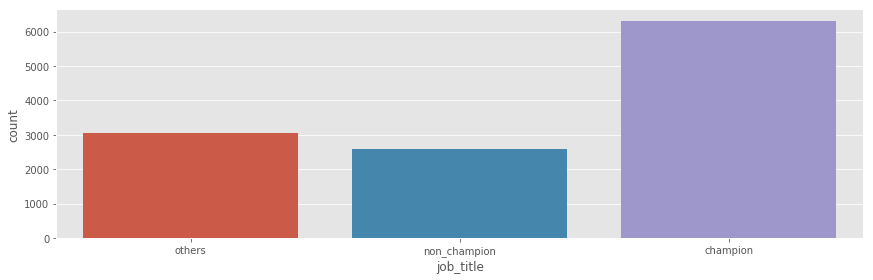

In [72]:
sns.factorplot(x="job_title",
                    data=df, kind="count",
                    size=4, aspect=3);

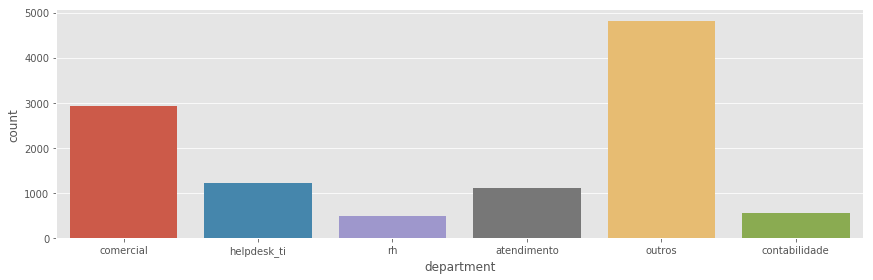

In [73]:
sns.factorplot(x="department",
                    data=df, kind="count",
                    size=4, aspect=3);

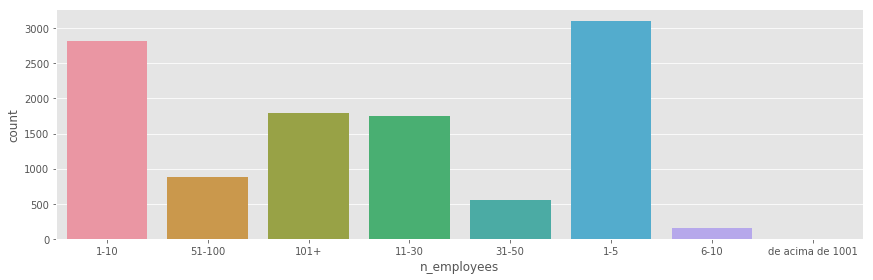

In [74]:
sns.factorplot(x="n_employees",
                    data=df, kind="count",
                    size=4, aspect=3);

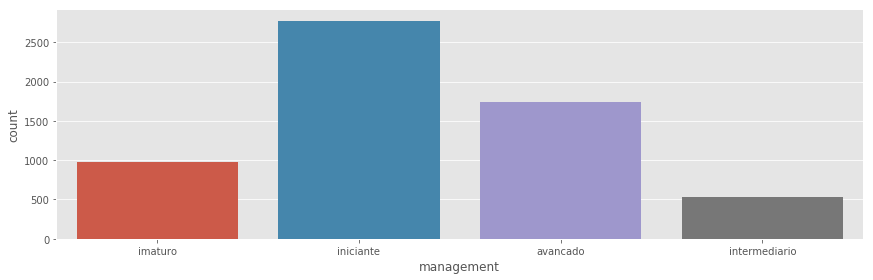

In [75]:
sns.factorplot(x="management",
                    data=df, kind="count",
                    size=4, aspect=3);

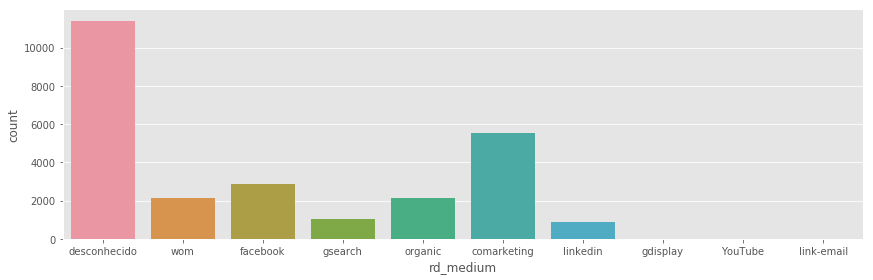

In [76]:
sns.factorplot(x="rd_medium",
                    data=df, kind="count",
                    size=4, aspect=3);

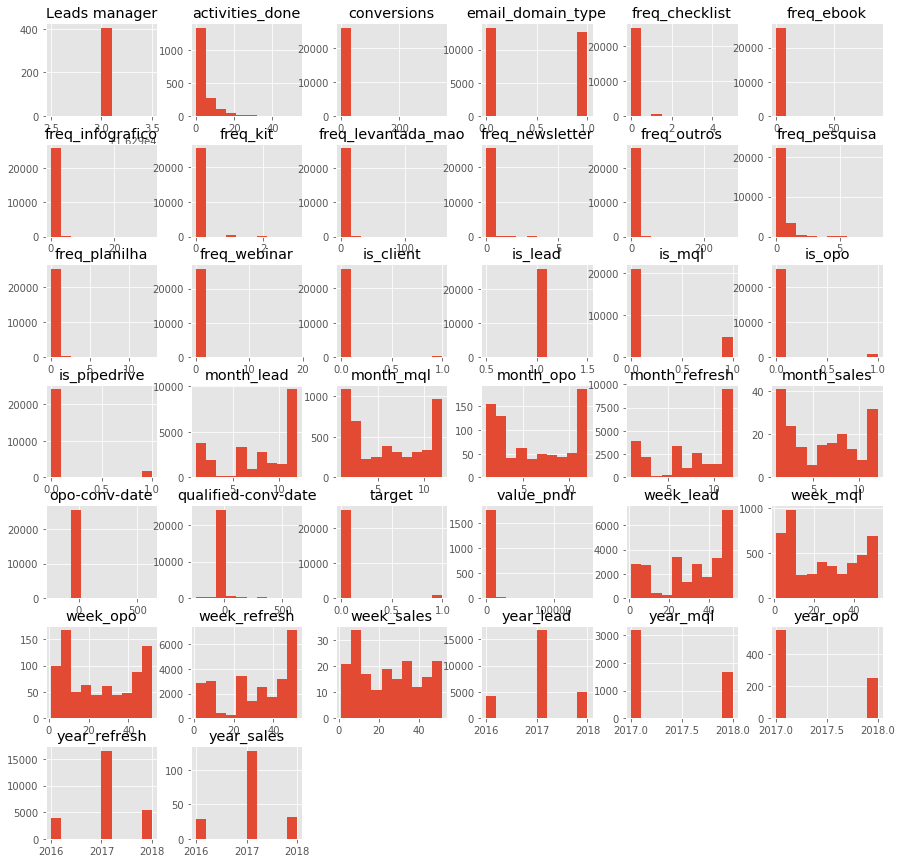

In [77]:
pd.DataFrame.hist(df, figsize = [15,15]);